## boilerplate code

In [1]:
import supy as sp
import pandas as pd
import numpy as np
from pathlib import Path
p_dir_input = Path("../data/saveairport_base")

/Users/tingsun/Dropbox (Personal)/6.Repos/SUEWS-DB-test/.venv/lib/python3.10/site-packages/supy/_post.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_var_list = df_var_list.applymap(lambda x: x.decode().strip())


## load in observation data

In [3]:
# load in observation data
p_obs = p_dir_input / "Saeve_asphalt_QGmeasured.csv"
df_obs_raw = pd.read_csv(p_obs, sep=";")

# convert to datetime
ser_year = pd.to_datetime(df_obs_raw.year.astype(str) + "-01-01")
# df_obs_raw.dectime
ser_dt=ser_year+pd.to_timedelta(df_obs_raw.dectime, unit="D").dt.round("30T")
df_obs=df_obs_raw.copy()
df_obs["datetime"]=ser_dt
df_obs.set_index("datetime", inplace=True)
df_obs.drop(columns=["year", "dectime"], inplace=True)
ser_qg = df_obs.QgHFP.rename("QG_obs")
ser_qg

datetime
2004-02-13 00:30:00   -19.3071
2004-02-13 01:00:00   -23.3299
2004-02-13 01:30:00   -17.3894
2004-02-13 02:00:00   -18.9956
2004-02-13 02:30:00   -17.8314
                        ...   
2004-04-14 10:00:00    42.4111
2004-04-14 10:30:00    37.0367
2004-04-14 11:00:00    24.0528
2004-04-14 11:30:00    68.7589
2004-04-14 12:00:00    34.1533
Name: QG_obs, Length: 2952, dtype: float64

## simulations

In [2]:

p_runcontrol = p_dir_input / "RunControl.nml"
df_state_base = sp.init_supy(p_runcontrol)

df_forcing = sp.load_forcing_grid(p_runcontrol, 1)

2024-03-16 23:43:48,295 - SuPy - INFO - All cache cleared.


In [5]:
# OHM
df_output_base, df_state_final = sp.run_supy(df_forcing, df_state_base)

2024-03-16 23:43:56,208 - SuPy - INFO - ====================
2024-03-16 23:43:56,209 - SuPy - INFO - Simulation period:
2024-03-16 23:43:56,209 - SuPy - INFO -   Start: 2004-02-12 00:05:00
2024-03-16 23:43:56,210 - SuPy - INFO -   End: 2004-04-14 21:00:00
2024-03-16 23:43:56,210 - SuPy - INFO - 
2024-03-16 23:43:56,210 - SuPy - INFO - No. of grids: 1
2024-03-16 23:43:56,211 - SuPy - INFO - SuPy is running in serial mode
2024-03-16 23:43:58,457 - SuPy - INFO - Execution time: 2.2 s
2024-03-16 23:43:58,458 - SuPy - INFO - ====================



In [6]:
# EHC as heat storage scheme
df_state_ehc = df_state_base.copy()
df_state_ehc.storageheatmethod = 5

# modify the depth of the vertical layers
ar_depth = np.repeat(np.array([[0.1, 0.1, 0.5, 2, 3]]), 7, axis=0).flatten()
df_state_ehc.loc[:, "dz_surf"] = ar_depth

# # modify the heat capacity of the vertical layers
# ar_cp = np.repeat(np.array([[2.2, 2.2, 2.2, 2.2, 2.2]])*1e6, 7, axis=0).flatten()
# df_state_ehc.loc[:, "cp_surf"] = ar_cp

# # modify the thermal conductivity of the vertical layers
# ar_k = np.repeat(np.array([[1.1, 1.1, 1.1, 1.1, 1]]) * 1.5, 7, axis=0).flatten()
# df_state_ehc.loc[:, "k_surf"] = ar_k

df_output_ehc, df_state_final = sp.run_supy(df_forcing, df_state_ehc)

2024-03-16 23:43:58,465 - SuPy - INFO - ====================
2024-03-16 23:43:58,465 - SuPy - INFO - Simulation period:
2024-03-16 23:43:58,466 - SuPy - INFO -   Start: 2004-02-12 00:05:00
2024-03-16 23:43:58,466 - SuPy - INFO -   End: 2004-04-14 21:00:00
2024-03-16 23:43:58,466 - SuPy - INFO - 
2024-03-16 23:43:58,467 - SuPy - INFO - No. of grids: 1
2024-03-16 23:43:58,467 - SuPy - INFO - SuPy is running in serial mode
2024-03-16 23:44:00,700 - SuPy - INFO - Execution time: 2.2 s
2024-03-16 23:44:00,701 - SuPy - INFO - ====================



### result comparison

,base,ehc,obs
datetime,,,
2004-02-13 00:30:00,-55.441880,-4.192190,-19.3071
2004-02-13 01:00:00,-55.449247,-4.404584,-23.3299
2004-02-13 01:30:00,-55.457809,-4.509476,-17.3894
2004-02-13 02:00:00,-55.466135,-4.573120,-18.9956
2004-02-13 02:30:00,-55.482799,-4.357476,-17.8314
...,...,...,...
2004-04-14 10:00:00,52.342414,27.776579,42.4111
2004-04-14 10:30:00,59.945842,34.410089,37.0367
2004-04-14 11:00:00,61.307841,38.743342,24.0528


<Axes: xlabel='datetime'>

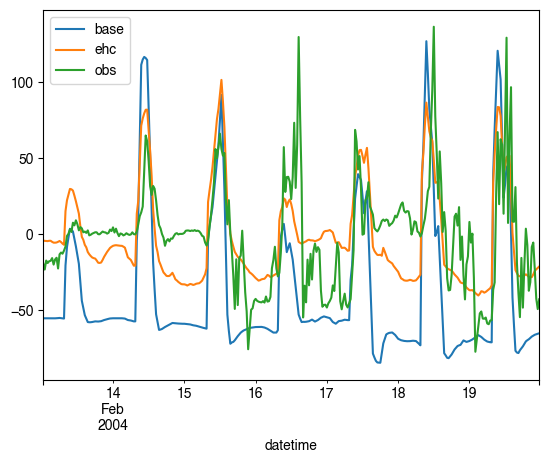

In [7]:
df_comp = (
    pd.concat([df_output_base, df_output_ehc], axis=1, keys=["base", "ehc"])
    .swaplevel(axis=1, i=1, j=0)
    .swaplevel(axis=1, i=1, j=2)
    .sort_index(axis=1)
)
df_comp_qs = df_comp.loc[1, "SUEWS"].QS
df_comp_qs = df_comp_qs.assign(obs=ser_qg).dropna()
df_comp_qs
df_comp_qs.loc['2004-2-13':'2004-2-19'].plot()

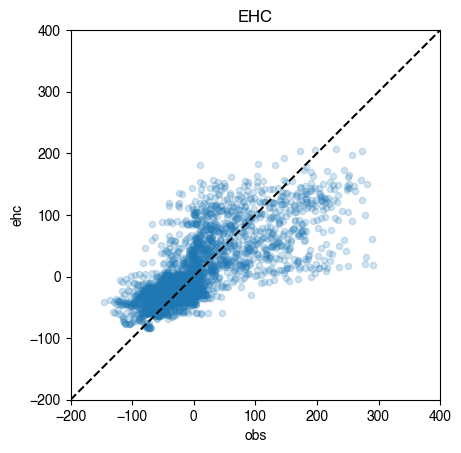

In [17]:
ax = df_comp_qs.plot.scatter(x="obs", y="ehc", alpha=0.2, style="..", title="EHC")
_ = ax.set_aspect("equal", "box")
_ = ax.set_xlim(-200, 400)
_ = ax.set_ylim(-200, 400)
_ = ax.plot([-200, 400], [-200, 400], "k--")

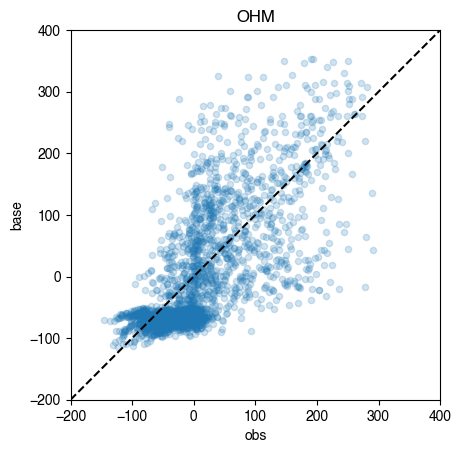

In [18]:
ax = df_comp_qs.plot.scatter(x="obs", y="base", alpha=0.2, style="..", title="OHM")
_ = ax.set_aspect("equal", "box")
_ = ax.set_xlim(-200, 400)
_ = ax.set_ylim(-200, 400)
_ = ax.plot([-200, 400], [-200, 400], "k--")

In [11]:
# compare the performance of the two simulations
df_comp_qs.corr()


,base,ehc,obs
base,1.000000,0.945551,0.721991
ehc,0.945551,1.000000,0.740940
obs,0.721991,0.740940,1.000000


In [12]:
df_comp_qs.corr(method="spearman")

,base,ehc,obs
base,1.000000,0.870257,0.714558
ehc,0.870257,1.000000,0.757080
obs,0.714558,0.757080,1.000000


In [16]:
# calculate RMSE for the two simulations
rmse_base = np.sqrt(((df_comp_qs.obs - df_comp_qs.base) ** 2).mean())
rmse_ehc = np.sqrt(((df_comp_qs.obs - df_comp_qs.ehc) ** 2).mean())
rmse_base, rmse_ehc


(66.44443384966173, 49.73062062638881)